## Additional Challenges
## UD-MIS Classical and Quantum Benchmarking

This code is intended to benchmark the scaling of the classical to D-Wave
execution.

The code has been modified to run the UD-MIS algorithm until there is no change
in the energy (after 300 steps)

We try different size graphs of the UD-MIS formulation and also track the
lowest energy found with both the classical UD-MIS solver and the D-Wave
quantum annealer

Using D-Wave 2000Q we were only able to go up to a maximum node size of 70. We ran Advantage to maximum nodes of 100.

We had to change the parameters to get the best results as shown below:


chain strength=nodes/5

annealing time=nodes*7

number of runs=nodes*10

### D-Wave 2000Q

The graph below shows the comparison of time taken by the classical method vs 2000Q (with optimal settings)


size 0=10,1=20,2=30,3=40,4=50,5=60 ,6=70 (max for D-Wave 200Q), 7=80

<img src="./resources/benchmark UDMIS classical quantum run 2 time.png" width="300" align="center">

The graph below shows the comparison of the lowest energy found by classical and D-Wave 2000Q.  

<img src="./resources/benchmark UDMIS classical quantum run 2 energy.png" width="300" align="center">

### D-Wave Advantage

The graph below shows the comparison of time taken by the classical method vs D-Wave advantage (with optimal settings)

<img src="./resources/benchmark UDMIS classical quantum adv run 4 time.png" width="300" align="center">

The graph below shows the comparison of the lowest energy found by classical and D-Wave advantage.  

<img src="./resources/benchmark UDMIS classical quantum adv run 4 energy.png" width="300" align="center">

As can be noticed, with larger nodes, D-Wave is not able to find the lowest energy, as found classically.


Even with the high amount of sampling only a few results reached down to the lower values as seen in this histogram for 40 nodes:

<img src="./resources/DWave sampling Energy values for 40 nodes.png" width="300" align="center">

and for 100 nodes:

<img src="./resources/DWave sampling Energy values for 100 nodes.png" width="300" align="center">

We expect that as the quantum computers improve their ability to find the lowest value will increase. In any case,
we find that D-Wave returns values orders of magnitude faster than the classical method. Even though we do not
get the lowest energy, we get a large sampling of answers that for some time sensitive purposes can be beneficial.

We also expect that one can evaluate the corresponding "business value" of the Energy values. This will help in identifying 
the incremental business advantage of finding a lower energy value.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from abstract_udmis import AbstractUDMIS
from matplotlib import pyplot as plt
from numpy.random import rand
import time

In [2]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from minorminer import find_embedding
import networkx as nx
import dwave.inspector

In [3]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, edges):
        super().__init__()
        self.u, self.edges = u, edges
        self.num_vertices = len(self.edges)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices) 

In [4]:
def generate_node_graph(title=None, occupations=None):

    if title is None:
        title = 'Graph Representation of Proteins Similarities'

    np.random.seed(0)

    fig, ax = plt.subplots()

    n_nodes = len(Q)
    G = nx.Graph()

    for i in range(n_nodes):
        # G.add_node(i, pos=(graph[i][0], graph[i][1]))
        G.add_node(i, pos=(np.random.randint(100), np.random.randint(100)))  # Generate random positions

    edge_list = []
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if edges[i, j] == True:
                G.add_edge(i, j)
                edge_list.append([i, j])


    pos = nx.get_node_attributes(G, 'pos')

    nx.draw_networkx_nodes(G,pos, ax=ax, node_color='y' if occupations is None else ['g' if occ else 'y' for occ in occupations])
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color='y')

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.show()

In [5]:
def benchmark(edges):
    N = 100000
    t = np.arange(N+1)
    T_i = 100
    T_f = 0.01

    no_change=0
    max_no_change=0
    
    T = T_i * ((T_f/T_i) ** (t/N))

    udmis = UDMIS(u, edges)

    # Keep track of energy and solutions (this might take up some memory)
    #energy_history = np.zeros(N)
    #solution_history = np.zeros([N, udmis.num_vertices])
    energy_previous=-999999
    for t in range(N):
        # take a look at the abstract_udmis.py file to see how mc_step works
        temp = T[t]
        E = udmis.mc_step(T=temp)

        #energy_history[t] = E
        #solution_history[t] = udmis.occupations
        if E != energy_previous:
            energy_previous=E
            #print(t, E, udmis.occupations)
            if no_change>max_no_change:
                max_no_change=no_change
            no_change=0
        else:
            #print('no change in Energy', no_change)
            no_change+=1
            if no_change==300:
                print('C', E)
                return(E)
    return(False)
    

In [6]:
e1=[]
r1=[]
e2=[]
r2=[]
d=[]
u = 1.35
for dim in [20,40,60,80,100]:
    d.append(dim)
    # create a random matrix
    Q = 2*rand(dim,dim) - 1
    Q = (Q+Q.T)/2
    for k in range(dim):
        Q[k,k] = np.abs(Q[k,k])
    edges = Q> 0.2
    np.fill_diagonal(edges, False)
    
    start = time.time()
    r1.append(benchmark(edges))
    execution_time = time.time()-start
    e1.append(execution_time)
    
    # Now D-Wave run
    
    qpu_advantage = DWaveSampler(solver={'topology__type': 'pegasus'})
    qpu_2000q = DWaveSampler(solver={'topology__type': 'chimera'})
    #hybrid_bqm_sampler = LeapHybridSampler()
    #print(qpu_2000q.properties["annealing_time_range"])
    #print(qpu_2000q.properties["default_annealing_time"]) 
    #print(qpu_advantage.properties["annealing_time_range"])
    #print(qpu_advantage.properties["default_annealing_time"]) 
    
    linear={(k, k):-1 for k in range(dim)}
    quadratic={(i, j):1 for i in range(dim) for j in range(dim) if edges[i,j]==1 and j<i+1}
    
    QDwave = dict(linear)
    QDwave.update(quadratic)
    
    #chain_strength 0-20
    cs=dim/5
    # annealing time 20-2000
    at=dim*7
    # number of runs 10 to 10000
    nr=dim*10
    
    label='CDLw2b-'+str(dim)+'cs'+str(cs)+'at'+str(at)+'nr'+str(nr)

    sampler = EmbeddingComposite(DWaveSampler())
    
    start = time.time()
    response = sampler.sample_qubo(QDwave, chain_strength=cs, annealing_time=at, num_reads=nr, label=label)
    execution_time = time.time()-start
    e2.append(execution_time)
    
    # Store D-Wave result
    b_result=[]
    first=True
    for i in response.data():
        if first==True:
            r2.append(i.energy)
            i_energy=i.energy
            first=False        
            #print(i.sample)
            for j in i.sample:


                if j==1:
                    b_result.append(True)
                else:
                    b_result.append(False)

    print('Q', i_energy)

20
C -7.0
Q -7.0
40
C -10.0
Q -5.0
60
C -12.0
Q -3.0
80
C -12.0
Q 7.0
100
C -13.0
Q 31.0


In [7]:
print(e1)
print(r1)
print(e2)
print(r2)

[76.78502345085144, 244.01380586624146, 545.0296151638031, 912.3281209468842, 1372.67440199852]
[-7.0, -10.0, -12.0, -12.0, -13.0]
[0.24534392356872559, 2.2899281978607178, 10.863991260528564, 21.089369535446167, 27.9592604637146]
[-7.0, -5.0, -3.0, 7.0, 31.0]


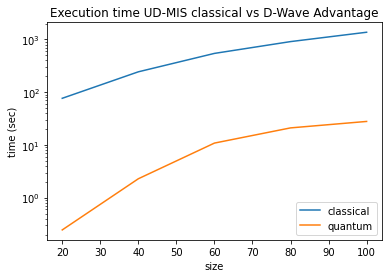

In [8]:
# Function to plot  
plt.plot(d,e1)
plt.plot(d,e2)
plt.title('Execution time UD-MIS classical vs D-Wave Advantage')
# Function add a legend  
plt.legend(["classical", "quantum"], loc ="lower right")
plt.yscale('log')
# function to show the plot
plt.xlabel('size')
plt.ylabel('time (sec)')
plt.show()

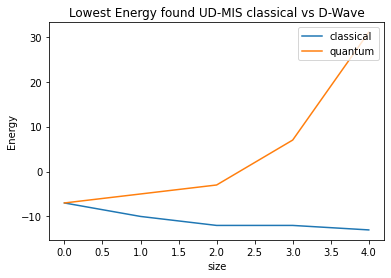

In [9]:
# Function to plot  
plt.plot(r1)
plt.plot(r2)
plt.title('Lowest Energy found UD-MIS classical vs D-Wave') 
# Function add a legend  
plt.legend(["classical", "quantum"], loc ="upper right")
plt.xlabel('size')
plt.ylabel('Energy')
# function to show the plot
plt.show()